In [37]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir

In [38]:
class particle:
    def __init__(self, pid, fourvector, Q2, Nu):
        #In the lab frame, but with the photon is aligned with z-direction, the photon has 4-momentum q= (0,0,sqrt(Nu2+Q2),Nu) (note q2 = -Q2)        
        self.virtual_photon = ROOT.TLorentzVector()
        self.virtual_photon.SetPxPyPzE(0,0,np.sqrt(Nu*Nu+Q2),Nu)
        self.virtual_photon_CM = self.virtual_photon
        self.proton = ROOT.TLorentzVector()
        self.proton.SetPxPyPzE(0,0,0, 0.938)
        self.proton_CM = self.proton
        
        self.W = (self.virtual_photon + self.proton).M()
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.0,5.0)####INCONSISTENT
        part1 = self.virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = self.virtual_photon.Vect().Cross(fourvector.Vect()).Unit()
        sign  = np.sign(part1.Dot(fourvector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2))
        
        photon_pz = np.sqrt(Nu*Nu+Q2) #direction is positive by definition
        self.bcm = photon_pz/(Nu + 0.938)#photon-nucleon center-of-mass velocity 
        self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
        self.virtual_photon_CM.Boost(0.0,0.0,-self.bcm)
        self.proton_CM.Boost(0.0,0.0,-self.bcm)
        
        self.LorentzVector = fourvector #hadron four-vector
        self.PhiLab = self.LorentzVector.Phi()
        self.E = self.LorentzVector.E() #energy in lab frame
        self.vector = self.LorentzVector.Vect()
        self.Pt = self.vector.Perp(self.virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.vector.Dot(self.virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
        self.mass = self.LorentzVector.M() 
        self.y_star = self.y - self.ycm
        self.Pl_star = self.mT*np.sinh(self.y_star)
        self.Pstar = np.sqrt(self.Pl_star*self.Pl_star + self.Pt*self.Pt)
        self.eta = np.arctanh(self.Pl_star/self.Pstar)
        #self.eta =  0.5*np.log( (self.Pstar+self.Pl_star)/(self.Pstar-self.Pl_star)) 
        
        self.Xf = 2.0*self.Pl_star/self.W 
        self.pid = pid
        self.Zh = self.E/Nu
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        self.Xb = Q2/(2*0.938*Nu)

        #'phi =%2.2f'%self.PhiLab,
    def print_properties(self):
        #print ('Hello, let me introduce myself, i am particle pid = ' , self.pid)
        #print ('PID', self.pid, ' zh = %2.2f'%self.Zh,  'E = %2.2f'%self.E, 'phi =%2.2f'%self.PhiLab,'theta=%2.2f'%self.LorentzVector.Theta(),'pt %2.2f'%self.Pt)
        print ('PID', self.pid, ' pT = %2.2f'%self.Pt,  'Pl= %2.2f'%self.Pl_star, 'Xf=%2.2f'%self.Xf, 'Zh=%2.2f'%self.Zh, 'phi =%2.2f'%self.PhiLab)

        
        #print ('%2.3f,'%self.LorentzVector.Px(),'%2.3f,'%self.LorentzVector.Py(),'%2.3f,'%self.LorentzVector.Pz(), '%2.23f,'%self.LorentzVector.E())


In [39]:
class mytupla:
    def __init__(self):
        self.tupla = {}
        variables = ['dphi','dphi_lab','qt','drap','h1_z','h2_z','z_tot','h1_xf','h2_xf',
                     'h1_rap', 'ycm','h2_rap','h1_pid','h2_pid','h1_cm_ph','h2_cm_ph',
                      'h1_cm_th','h2_cm_th','pair_mass','pair_pt','mx_eh1h2',
                      'Q2','x','nu','W','h1_ph','h1_th','h2_ph','h2_th',
                       'pos_x', 'pos_y','pos_z','pos_x_asso', 'pos_y_asso','pos_z_asso']
        
        for var in variables:
            self.tupla[var] = []
        
        trigger_variables = ['h1_pid','h1_xf','h1_z','h1_rap','ycm','h1_pt','Q2','x','nu','W','h1_cm_ph','h1_cm_th','mass', 'pstar','plstar','eta',
                             'TargType','h1_ph','h1_th','pos_x','pos_y','pos_z']
        
        self.tupla_hadron = {}
        for var in trigger_variables:
            self.tupla_hadron[var] = []    

In [40]:

def getDataframes(filename, Target=1,maxevents=1e9,beamenergy=5.0):
    dphi = np.array([])
    ParticlesFromPrevious = []
    try:
        myfile = TFile.Open('%s'%filename,'READ')
    except:
        print("could not open file")

        
    myfile.Print()
    mytree = myfile.Get('RootTuple')
    
    print (filename, ' has ', mytree.GetEntries(), ' entries')
    print ('The max number of events to be analyzes is ', maxevents)
    df = mytupla()    
    
    start = time.time()
    for ievt  in range(mytree.GetEntries()):
        if(ievt%1e5==0):
            print ('Event # ', ievt)
            end = time.time()
            print ('Processed in',  end-start, 'seconds')
            start = time.time()
        mytree.GetEntry(ievt)   
        if mytree.Q2<1.0: continue
        if ievt>maxevents: break
        Nu = mytree.nu
        Q2 = mytree.Q2
        phi_e = mytree.phiL 
        E    = beamenergy
        Eprime = E-Nu
        
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,E,E)
        
        #scattered electron
        scattered_e = ROOT.TLorentzVector()
        cos_thetae = 1-Q2/(2*E*Eprime)
        sin_thetae = np.sqrt(1-cos_thetae*cos_thetae)
        scattered_e.SetPxPyPzE(Eprime*sin_thetae*np.cos(phi_e),
                               Eprime*sin_thetae*np.sin(phi_e),
                               Eprime*cos_thetae,
                               Eprime)
        virtual_photon  = incoming_e - scattered_e
        virtual_photon_unitvector = virtual_photon.Vect().Unit()

        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,0, 0.938)
        #print virtual_photon.M2(), ' ' , Q2
        #print virtual_photon.Vect().Mag(), ' ' , np.sqrt(Nu*Nu+Q2*Q2)
        
        #virtual_photon = ROOT.TLorentzVector()
        #virtual_photon.SetPxPyPzE( 0, 0, np.sqrt(Nu*Nu+Q2*Q2),Nu)  #lab frame but with z in photon direction 
        #cos_thetaphoton = E -Eprime
        
        #need to rotate to lab frame with z aligned with beam frame
        #virtual_photon.Rotate()
        #### virtual photon 
        #electron in lab frame = (0,0,E,E)
        #scattered electron in lab frame = (E'sintheta*cosphi,E'sintheta'sinphi,E'costheta,E')
        
        #Q2= 2EE'(1-cos_thetae)
        # cos_thetae =1- Q2/2EE'

        #photon in lab frame is e-e'
        # (-E'sintheta*cosphi, -E'sintheta*sinphi, E-E'costheta, E-E')
        
        #cos_thetaphoton = (E- E'*costheta)/(E-E')
        #cos_thetaphoton = (E- E'*(1- Q2/2EE'))/(E-E')
        #sin_thetaphoton = sqrt(1-cos_thetaphoton*cos_thetaphoton)
        #Thus, photon pT in lab frame with z-lepton direction is:
        #pT = E'sqrt(1-cos_thetaphoton^{2})
        #pT = E'sqrt(1- (E- E'*(1- Q2/2EE'))/(E-E')^{2} )
        #and finally, photon phi angle is:
        # phi_photon = -phi_electron (given)
      
        for i in range(len(mytree.Px)):
            if abs(mytree.barcode[i]) !=211: continue
            i_lv = ROOT.TLorentzVector()    
            i_lv.SetPxPyPzE(mytree.Px[i],mytree.Py[i],mytree.Pz[i],mytree.E[i]) #with respect to photon direction
            i_part = particle(mytree.barcode[i], i_lv, Q2, Nu)
            if i_part.Zh > 0.5:
                df.tupla_hadron['TargType'].append(999)
                df.tupla_hadron['h1_pid'].append(i_part.pid)
                df.tupla_hadron['h1_xf'].append(i_part.Xf)
                df.tupla_hadron['h1_z'].append(i_part.Zh)
                df.tupla_hadron['h1_rap'].append(i_part.y_star)
                df.tupla_hadron['ycm'].append(i_part.ycm)
                df.tupla_hadron['h1_pt'].append(i_part.LorentzVector.Pt())
                df.tupla_hadron['h1_ph'].append(i_part.PhiPQ)
                df.tupla_hadron['h1_th'].append(i_part.ThetaPQ)
                df.tupla_hadron['Q2'].append(Q2)
                df.tupla_hadron['x'].append(i_part.Xb)
                df.tupla_hadron['nu'].append(Nu)
                df.tupla_hadron['W'].append(i_part.W)
                df.tupla_hadron['h1_cm_ph'].append(i_part.LorentzVector.Phi())
            
                df.tupla_hadron['h1_cm_th'].append(i_part.LorentzVector.Theta())
                df.tupla_hadron['mass'].append(i_part.mass)
                df.tupla_hadron['eta'].append(i_part.eta)
                df.tupla_hadron['pstar'].append(i_part.Pstar)
                df.tupla_hadron['plstar'].append(i_part.Pl_star)

                df.tupla_hadron['pos_x'].append(mytree.x[i])
                df.tupla_hadron['pos_y'].append(mytree.y[i])
                df.tupla_hadron['pos_z'].append(mytree.z[i])
                
                for j in range(len(mytree.Px)): 
                    if i==j: continue
                    if abs(mytree.barcode[j]) !=211: continue
                    j_lv = ROOT.TLorentzVector()    
                    j_lv.SetPxPyPzE(mytree.Px[j],mytree.Py[j],mytree.Pz[j],mytree.E[j])
                    j_part = particle(mytree.barcode[j], j_lv, Q2, Nu)
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-j_part.PhiPQ))
                    dphi_lab = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiLab-j_part.PhiLab))
                    dipion = i_part.LorentzVector+j_part.LorentzVector
                    qt = dipion.Pt()
                    X = (virtual_photon + proton - dipion) #unobserved hadronic system

                    
            
                    
                    df.tupla['dphi_lab'].append(dphi)
                    df.tupla['dphi'].append(dphi_lab)
                    df.tupla['qt'].append(qt)
                    df.tupla['drap'].append(i_part.y_star-j_part.y_star)
                    df.tupla['h1_z'].append(i_part.Zh)
                    df.tupla['h2_z'].append(j_part.Zh)
                    df.tupla['z_tot'].append(i_part.Zh+j_part.Zh)
                    df.tupla['h1_xf'].append(i_part.Xf)
                    df.tupla['h2_xf'].append(j_part.Xf)
                    df.tupla['h1_rap'].append(i_part.y_star)
                    df.tupla['ycm'].append(i_part.ycm)
                    df.tupla['h2_rap'].append(j_part.y_star)
                    df.tupla['h1_pid'].append(i_part.pid)
                    df.tupla['h2_pid'].append(j_part.pid)
                    df.tupla['h1_ph'].append(i_part.PhiPQ)
                    df.tupla['h2_ph'].append(j_part.PhiPQ)
                    df.tupla['h1_th'].append(i_part.ThetaPQ)
                    df.tupla['h2_th'].append(j_part.ThetaPQ)
                    df.tupla['pair_mass'].append(dipion.M())
                    df.tupla['pair_pt'].append( dipion.Pt())
                    df.tupla['mx_eh1h2'].append(X.M())
                    df.tupla['Q2'].append(Q2)
                    df.tupla['x'].append(i_part.Xb)
                    df.tupla['nu'].append(Nu)
                    df.tupla['W'].append(i_part.W)
                    df.tupla['h1_cm_ph'].append(i_part.LorentzVector.Phi())
                    df.tupla['h1_cm_th'].append(i_part.LorentzVector.Theta())
                    df.tupla['h2_cm_ph'].append(j_part.LorentzVector.Phi())
                    df.tupla['h2_cm_th'].append(j_part.LorentzVector.Theta())
                    df.tupla['pos_x'].append(mytree.x[i])
                    df.tupla['pos_y'].append(mytree.y[i])
                    df.tupla['pos_z'].append(mytree.z[i])
                    df.tupla['pos_x_asso'].append(mytree.x[j])
                    df.tupla['pos_y_asso'].append(mytree.y[j])
                    df.tupla['pos_z_asso'].append(mytree.z[j])
        
        
    end = time.time()
    print ('Processed in',  end-start, 'seconds')
    df_pair = pd.DataFrame(df.tupla)
    df_hadron = pd.DataFrame(df.tupla_hadron)
    return df_pair, df_hadron

In [41]:
df = {}

## Configuration for CLAS12

In [42]:
path = '/home/miguel/GiBUU/'

In [43]:
%%time
df['D'], df['D_trigger'] = getDataframes(path+'GiBUU_D.root',maxevents=1e7)

/home/miguel/GiBUU/GiBUU_D.root  has  8363332  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 1.5497207641601562e-05 seconds
Event #  100000
Processed in 10.724108695983887 seconds
Event #  200000
Processed in 10.609443187713623 seconds
Event #  300000
Processed in 10.688143014907837 seconds
Event #  400000
Processed in 10.654787063598633 seconds
Event #  500000
Processed in 10.697743654251099 seconds
Event #  600000
Processed in 10.625486135482788 seconds
Event #  700000
Processed in 10.675503015518188 seconds
Event #  800000
Processed in 10.717974185943604 seconds
Event #  900000
Processed in 10.666571378707886 seconds
Event #  1000000
Processed in 10.563978910446167 seconds
Event #  1100000
Processed in 10.590094804763794 seconds
Event #  1200000
Processed in 10.583815336227417 seconds
Event #  1300000
Processed in 10.768549919128418 seconds
Event #  1400000
Processed in 10.761897802352905 seconds
Event #  1500000
Processed in 10.7151238918304

In [44]:
%%time
df['C'], df['C_trigger'] = getDataframes(path+'GiBUU_C.root',maxevents=1e7)

/home/miguel/GiBUU/GiBUU_C.root  has  21776066  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 2.6941299438476562e-05 seconds
Event #  100000
Processed in 11.098126411437988 seconds
Event #  200000
Processed in 11.08291220664978 seconds
Event #  300000
Processed in 11.097013235092163 seconds
Event #  400000
Processed in 11.205393552780151 seconds
Event #  500000
Processed in 11.219999313354492 seconds
Event #  600000
Processed in 11.211086750030518 seconds
Event #  700000
Processed in 11.281361103057861 seconds
Event #  800000
Processed in 11.224260568618774 seconds
Event #  900000
Processed in 11.107225179672241 seconds
Event #  1000000
Processed in 11.51197099685669 seconds
Event #  1100000
Processed in 11.583962678909302 seconds
Event #  1200000
Processed in 11.68247652053833 seconds
Event #  1300000
Processed in 11.60779356956482 seconds
Event #  1400000
Processed in 11.542730808258057 seconds
Event #  1500000
Processed in 11.395522832870483 

In [45]:
%%time
df['Fe'], df['Fe_trigger'] = getDataframes(path+'GiBUU_Fe.root',maxevents=1e7)

/home/miguel/GiBUU/GiBUU_Fe.root  has  5596315  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 4.9114227294921875e-05 seconds
Event #  100000
Processed in 11.358571290969849 seconds
Event #  200000
Processed in 11.272034645080566 seconds
Event #  300000
Processed in 11.338605880737305 seconds
Event #  400000
Processed in 11.555800914764404 seconds
Event #  500000
Processed in 11.562992095947266 seconds
Event #  600000
Processed in 11.419926881790161 seconds
Event #  700000
Processed in 11.333530187606812 seconds
Event #  800000
Processed in 11.300788164138794 seconds
Event #  900000
Processed in 11.243183612823486 seconds
Event #  1000000
Processed in 11.403878688812256 seconds
Event #  1100000
Processed in 11.454476594924927 seconds
Event #  1200000
Processed in 11.321228504180908 seconds
Event #  1300000
Processed in 11.384282350540161 seconds
Event #  1400000
Processed in 11.528863668441772 seconds
Event #  1500000
Processed in 11.307585000991

In [46]:
%%time
df['Pb'], df['Pb_trigger'] = getDataframes(path+'GiBUU_Pb.root',maxevents=1e7)

/home/miguel/GiBUU/GiBUU_Pb.root  has  8315826  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 2.384185791015625e-05 seconds
Event #  100000
Processed in 11.546709299087524 seconds
Event #  200000
Processed in 11.713501453399658 seconds
Event #  300000
Processed in 11.534658432006836 seconds
Event #  400000
Processed in 11.436219692230225 seconds
Event #  500000
Processed in 11.474177598953247 seconds
Event #  600000
Processed in 11.51873230934143 seconds
Event #  700000
Processed in 11.508025646209717 seconds
Event #  800000
Processed in 11.64437460899353 seconds
Event #  900000
Processed in 11.610306978225708 seconds
Event #  1000000
Processed in 11.785398006439209 seconds
Event #  1100000
Processed in 11.745120286941528 seconds
Event #  1200000
Processed in 11.627976655960083 seconds
Event #  1300000
Processed in 11.553746938705444 seconds
Event #  1400000
Processed in 11.556209564208984 seconds
Event #  1500000
Processed in 11.46756887435913 

In [47]:
import root_pandas
from root_pandas import read_root
from root_pandas import to_root 

In [48]:
print df['Pb'].shape[0]
print df['Pb_trigger'].shape[0]

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(df['Pb'].shape[0])? (<ipython-input-48-7a64ad9da4d0>, line 1)

In [ ]:
print (df['D'].shape[0])
print (df['D_trigger'].shape[0])

## Save dataframes to ROOT files

In [49]:
to_root(df['D'],'GiBUU_Pairs_D.root', key='D')
to_root(df['D_trigger'],'GiBUU_Pairs_D.root', key='D_trigger', mode='a')

In [50]:
to_root(df['C'],'GiBUU_Pairs_C.root', key='C')
to_root(df['C_trigger'],'GiBUU_Pairs_C.root', key='C_trigger', mode='a')

In [51]:
to_root(df['Fe'],'GiBUU_Pairs_Fe.root', key='Fe')
to_root(df['Fe_trigger'],'GiBUU_Pairs_Fe.root', key='Fe_trigger', mode='a')

In [52]:
to_root(df['Pb'],'GiBUU_Pairs_Pb.root', key='Pb')
to_root(df['Pb_trigger'],'GiBUU_Pairs_Pb.root', key='Pb_trigger', mode='a')

In [ ]:
## HERMES

In [ ]:
# to_root(df['D'],'GiBUU_Pairs_HERMES_D.root', key='D')
# to_root(df['D_trigger'],'GiBUU_Pairs_HERMES_D.root', key='D_trigger', mode='a')
# to_root(df['Kr'],'GiBUU_Pairs_HERMES_Kr.root', key='Kr')
# to_root(df['Kr_trigger'],'GiBUU_Pairs_HERMES_Kr.root', key='Kr_trigger', mode='a')

In [ ]:
# to_root(df['Xe'],'GiBUU_Pairs_HERMES_Xe.root', key='Xe')
# to_root(df['Xe_trigger'],'GiBUU_Pairs_HERMES_Xe.root', key='Xe_trigger', mode='a')

## CLAS12

In [ ]:
# to_root(df['D'],'GiBUU_Pairs_CLAS12_D.root', key='D')
# to_root(df['D_trigger'],'GiBUU_Pairs_CLAS12_D.root', key='D_trigger', mode='a')
# to_root(df['Pb'],'GiBUU_Pairs_CLAS12_Pb.root', key='Pb')
# to_root(df['Pb_trigger'],'GiBUU_Pairs_CLAS12_Pb.root', key='Pb_trigger', mode='a')

## Check dataframes variables

In [53]:
df['D']['dphi']

0          2.439464
1          2.729391
2          1.480757
3          2.673237
4          2.810301
             ...   
1282238    2.560213
1282239    2.522181
1282240    1.952735
1282241    2.276103
1282242    3.048682
Name: dphi, Length: 1282243, dtype: float64

In [54]:
df['D'].keys()

Index(['dphi', 'dphi_lab', 'qt', 'drap', 'h1_z', 'h2_z', 'z_tot', 'h1_xf',
       'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid', 'h1_cm_ph',
       'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt', 'mx_eh1h2',
       'Q2', 'x', 'nu', 'W', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', 'pos_x',
       'pos_y', 'pos_z', 'pos_x_asso', 'pos_y_asso', 'pos_z_asso'],
      dtype='object')

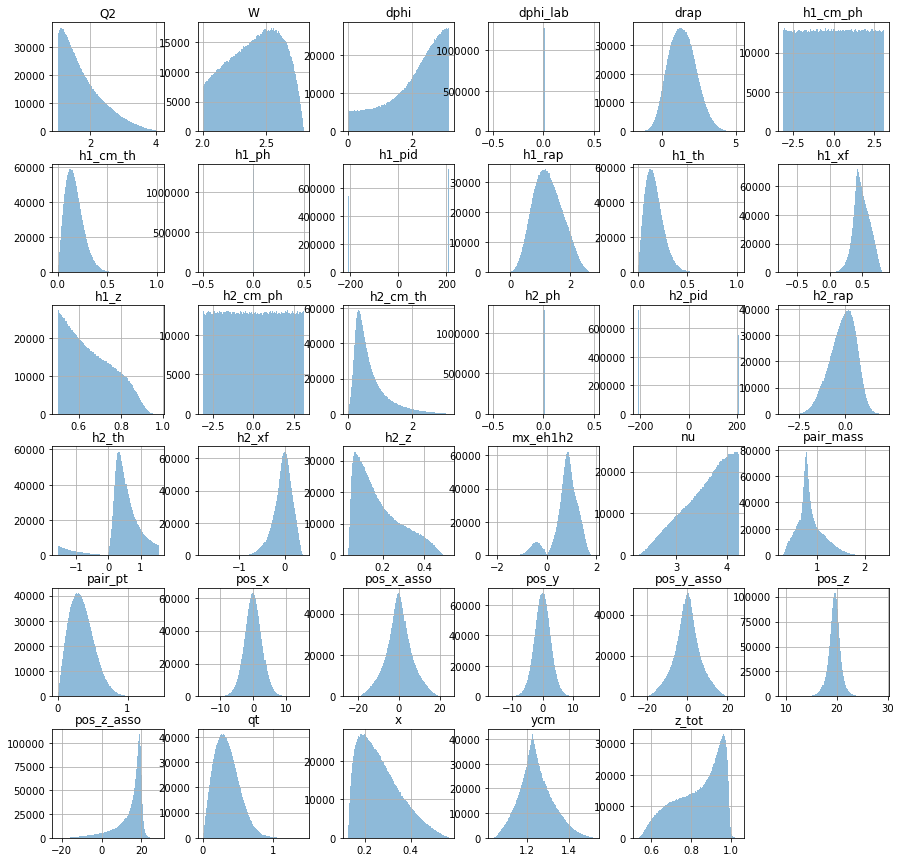

In [55]:
df['D'].query('h1_z>0.5').hist(figsize=(15, 15),alpha=0.5,bins=100)
plt.show()

In [ ]:
df['D_trigger'].hist(figsize=(15, 15),alpha=0.5,bins=20)
plt.show()

/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(data[col].dropna().values, bins=bins, **kwds)


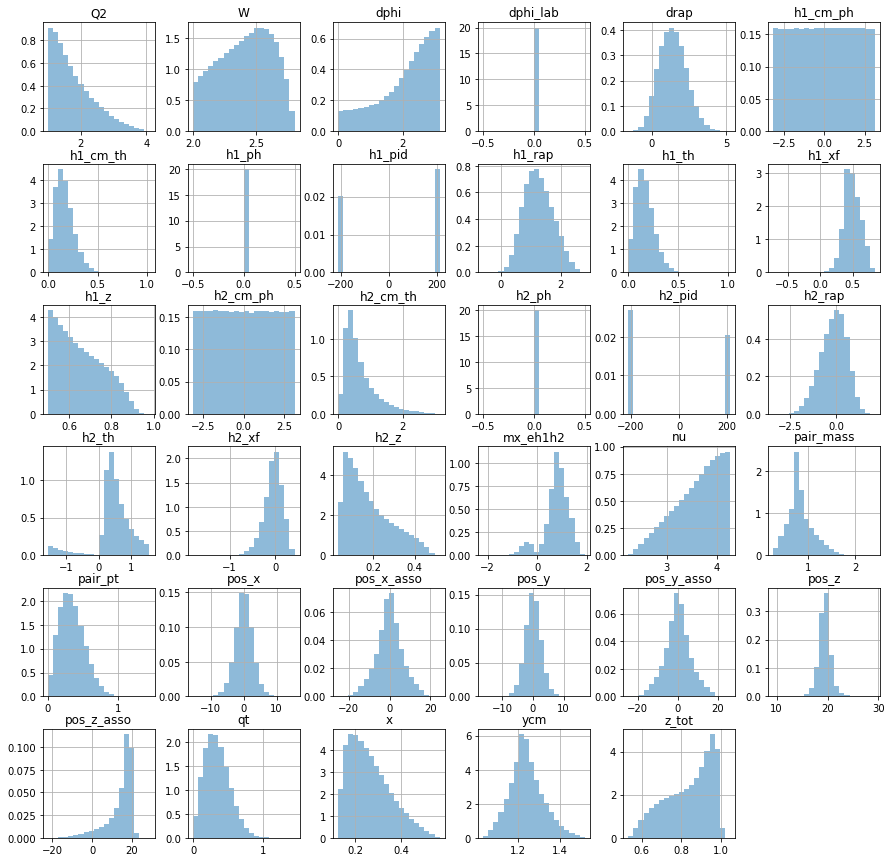

In [56]:
df['D'].hist(figsize=(15, 15),normed=True,alpha=0.5,bins=20)
plt.show()

<ipython-input-58-3bb06a02a3ba>:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  y_D, x , _  = plt.hist(df['D']['h2_z'],bins=100,normed=True,alpha=0.7,label='D')
<ipython-input-58-3bb06a02a3ba>:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  y_C, x , _  = plt.hist(df['Pb']['h2_z'],bins=100,normed=True,alpha=0.7,label='C')


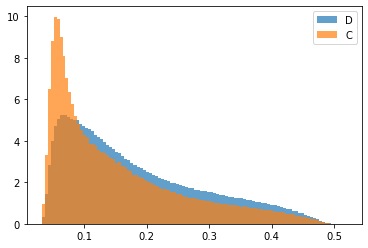

In [58]:
y_D, x , _  = plt.hist(df['D']['h2_z'],bins=100,normed=True,alpha=0.7,label='D')
y_C, x , _  = plt.hist(df['Pb']['h2_z'],bins=100,normed=True,alpha=0.7,label='C')
x = (x[1:] + x[:-1])/2.0
plt.legend()
plt.show()

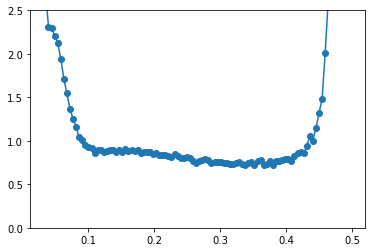

In [59]:
ratio = np.divide(y_C, y_D)
plt.errorbar(x, ratio, marker='o')

plt.ylim([0.0,2.5])
plt.show()

## Broadening